### Imports

In [10]:
%pip install pandas numpy matplotlib
%pip install scikit-learn seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

#### Fonction d'evaluation selon les métrics demande

In [12]:
def evaluate_model(model, X_val: np.ndarray, y_val: np.ndarray):
    """Evaluate the model using specified metrics."""
    predictions = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y_val, predictions),
        "Precision": precision_score(y_val, predictions, zero_division=0),
        "Recall": recall_score(y_val, predictions, zero_division=0),
        "F1-score": f1_score(y_val, predictions, zero_division=0),
        "ROC-AUC": roc_auc_score(y_val, probs) if probs is not None else "N/A"
    }

    for metric, value in metrics.items():
        print(f"{metric}: {value}" if isinstance(value, float) else f"{metric}: {value}")

#### class Tik-Tak

In [16]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

class RandomForestOptimizer:
    def __init__(self, param_ranges):
        self.param_ranges = param_ranges

    def initialize_model(self, params, param_ranges):
        n_estimators = int(param_ranges['n_estimators'][0] + params[0] * (param_ranges['n_estimators'][1] - param_ranges['n_estimators'][0]))
        max_depth = int(param_ranges['max_depth'][0] + params[1] * (param_ranges['max_depth'][1] - param_ranges['max_depth'][0]))
        min_samples_split = int(param_ranges['min_samples_split'][0] + params[2] * (param_ranges['min_samples_split'][1] - param_ranges['min_samples_split'][0]))
        min_samples_leaf = int(param_ranges['min_samples_leaf'][0] + params[3] * (param_ranges['min_samples_leaf'][1] - param_ranges['min_samples_leaf'][0]))

        return RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    def params_from_solution(self, solution: np.ndarray):
        params = {}
        for i, (param_name, (min_val, max_val)) in enumerate(self.param_ranges.items()):
            params[param_name] = int(solution[i] * (max_val - min_val) + min_val)
        return params

    def objective_function(self, solution: np.ndarray, X_train, y_train, X_val, y_val):
        model = RandomForestClassifier(**self.params_from_solution(solution))
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        return 1 - accuracy_score(y_val, predictions)

    

    def tiki_taka_optimization(self, population: np.ndarray, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, iterations: int = 10, exchange_rate: float = 0.1, exchange_intensity: float = 0.05):
        print('Starting Tiki-Taka optimization...')
        population = population.copy()

        for _ in range(iterations):
            # Exchanging information: Make slight modifications to solutions
            for i in range(population.shape[0]):
                current_solution = population[i].copy()

                # Determine how many elements to exchange based on the exchange rate
                num_exchanges = int(exchange_rate * population.shape[1])
                exchange_indices = np.random.choice(population.shape[1], num_exchanges, replace=False)

                # Make slight modifications at the chosen indices
                for idx in exchange_indices:
                    current_solution[idx] += np.random.uniform(-exchange_intensity, exchange_intensity)
                    current_solution[idx] = np.clip(current_solution[idx], 0, 1)  # Ensure it remains within bounds

                # Evaluate the fitness of the modified solution
                current_fitness = self.objective_function(current_solution, X_train, y_train, X_val, y_val)
                new_fitness = self.objective_function(population[i], X_train, y_train, X_val, y_val)

                # Accept the new solution if it is better
                if new_fitness < current_fitness:
                    population[i] = current_solution

        # Population Update: Rank solutions and keep the best
        population = np.array(sorted(population, key=lambda x: self.objective_function(x, X_train, y_train, X_val, y_val)))
        population = population[:population.shape[0]]  # Retain only the top solutions

        return population

    def optimize(self, population: np.ndarray, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, iterations: int = 10) -> np.ndarray:
        """Optimize the random forest parameters using Tiki-Taka optimization."""
         # Extract the parameters of the first individual in the population
        initial_solution = population[0]
        initial_params = self.params_from_solution(initial_solution)
        initial_model = RandomForestClassifier(**initial_params)

        # Print the initial parameters
        print("\nInitial Parameters for the First Individual:")
        for param, value in initial_params.items():
            print(f"{param}: {value}")
        # Apply Tiki-Taka to optimize the population
        population = self.tiki_taka_optimization(population, X_train, y_train, X_val, y_val, iterations)

        # Evaluate the best solution in the final population
        best_solution = population[0]
        best_params = self.params_from_solution(best_solution)
        best_model = RandomForestClassifier(**best_params)
        best_model.fit(X_train, y_train)

        print("\nOptimization Complete.")
        print("Best Parameters:", best_params)
        print("\nEvaluation Metrics:")
        self.evaluate_model(best_model, X_val, y_val)

        return population, best_model


    def evaluate_model(self, model, X_val, y_val):
        # Evaluate model performance on validation set
        predictions = model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        print(f"Accuracy: {accuracy}%")


#### main contenat le prepropcessing et l'appel des fonction

In [17]:
def main():
    # Load the data
    file_path = 'Facebook Dataset 9_9_2019.xlsx'
    data = pd.ExcelFile(file_path).parse('Sheet1')

    # Data cleaning and preprocessing
    data_cleaned = data.drop(columns=['Link'])

    # Handle missing values
    data_cleaned['Likes'].fillna(0, inplace=True)
    data_cleaned['Groups'].fillna(0, inplace=True)

    # Update to include new categorical columns
    categorical_columns = ['Education', 'Work', 'Living Place', 'Relationship \\ Family', 'Intro.', 'CLASS']
    numeric_columns = ['Likes', 'Groups', 'Mutual Friends', 'Posts', 'Tags']

    for col in categorical_columns:
        data_cleaned[col].fillna('Unknown', inplace=True)

    # Create processed dataset
    data_processed = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

    # Convert remaining object columns to numeric
    for col in data_processed.select_dtypes(include=['object']).columns:
        data_processed[col] = pd.to_numeric(data_processed[col], errors='coerce')

    # Convert boolean columns to int
    data_processed = data_processed.astype({col: 'int' for col in data_processed.select_dtypes(include=['bool']).columns})

    # Standardize numeric columns
    scaler = StandardScaler()
    data_processed[numeric_columns] = scaler.fit_transform(data_processed[numeric_columns])

    # Prepare data for feature selection
    data_clean = data_processed.dropna(subset=['CLASS_Real'])
    X_clean = data_clean.drop('CLASS_Real', axis=1)
    columns_to_drop = ['Profile Picture', 'CheckIn', 'Name_id']
    X_clean = X_clean.drop(columns=[col for col in columns_to_drop if col in X_clean.columns])
    y_clean = data_clean['CLASS_Real']

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X_clean)

    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=min(8, X_clean.shape[1]))
    X_new = selector.fit_transform(X_imputed, y_clean)
    selected_columns = X_clean.columns[selector.get_support()]
    print("\nSelected features:", selected_columns)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_clean, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Define parameter ranges for optimization
    param_ranges = {
        'n_estimators': (50, 200),
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    }

    # Initialize optimizer
    optimizer = RandomForestOptimizer(param_ranges)

    # Generate initial population
    population_size = 100
    population = np.random.random((population_size, len(param_ranges)))
    # Run optimization and evaluate first iteration
    first_model = optimizer.initialize_model(population[0], param_ranges)
    first_model.fit(X_train, y_train)
    print("\nFirst Iteration Evaluation on Validation Set:")
    evaluate_model(first_model, X_val, y_val)

    # Run optimization
    final_population, best_model = optimizer.optimize(
        population=population,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        iterations=20
    )

    print("\nFinal Evaluation on Test Set:")
    evaluate_model(best_model, X_test, y_test)

    # Feature importance visualization
    feature_importance = pd.DataFrame({
        'feature': selected_columns,
        'importance': best_model.feature_importances_
    })

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid", font_scale=1.2)  # Setting the style of the plot and scale of the font
    bar_plot = sns.barplot(data=feature_importance.sort_values('importance', ascending=False),
                           x='importance', y='feature', palette='viridis')
    
    plt.title('Feature Importance in the Random Forest Model')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    
    # Annotate each bar with its value
    for p in bar_plot.patches:
        width = p.get_width()    # get bar length
        plt.text(width,         # set the text at bar's right
                 p.get_y() + p.get_height() / 2,  # y is position at center
                 f'{width:.2%}',  # value of bar
                 va='center')  # vertical alignment
    
    plt.show()

C:\Users\allag\AppData\Local\Temp\ipykernel_9260\4230211388.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['Likes'].fillna(0, inplace=True)
C:\Users\allag\AppData\Local\Temp\ipykernel_9260\4230211388.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl


Selected features: Index(['Likes', 'Groups', 'Mutual Friends', 'Posts', 'Education_Not Exist',
       'Work_Not Exist', 'Living Place_Not Exist',
       'Relationship \ Family_Not Exist'],
      dtype='object')

First Iteration Evaluation on Validation Set:
Accuracy: 0.9798994974874372
Precision: 0.9885057471264368
Recall: 0.9885057471264368
F1-score: 0.9885057471264368
ROC-AUC: 0.9949425287356323

Initial Parameters for the First Individual:
n_estimators: 76
max_depth: 8
min_samples_split: 8
min_samples_leaf: 1
Starting Tiki-Taka optimization...

Optimization Complete.
Best Parameters: {'n_estimators': 88, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 3}

Evaluation Metrics:
Accuracy: 0.9798994974874372%

Final Evaluation on Test Set:
Accuracy: 0.9799196787148594
Precision: 0.985981308411215
Recall: 0.9906103286384976
F1-score: 0.9882903981264637
ROC-AUC: 0.9966092853416797


C:\Users\allag\AppData\Local\Temp\ipykernel_9260\4230211388.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=feature_importance.sort_values('importance', ascending=False),


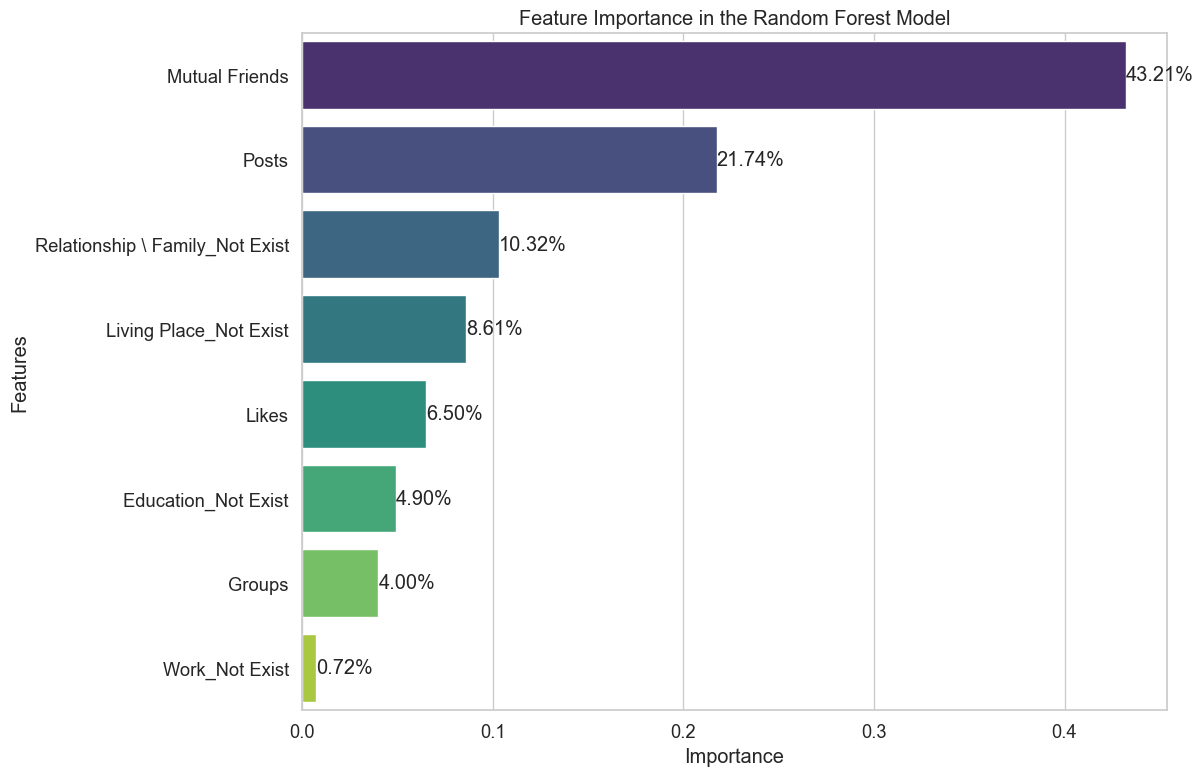

In [18]:
if __name__ == "__main__":
    main()